=== PUBLIC KEYS ===
Alice Public Key X: 0xcb850ddb329803e64f0f0940467b6bcdf015352ce494bc0d82a877b8c5c2ba22
Bob   Public Key X: 0xe7028219069dd6509975d8c2fe916b086430130af19de68b423a375087730f9

=== DERIVED SHARED KEY ===
Alice derived key: a221f273b4796e742e59ec3bea7e2ee2d76b0e7c8d4c9280b46cca211edc9531
Bob   derived key: a221f273b4796e742e59ec3bea7e2ee2d76b0e7c8d4c9280b46cca211edc9531
Keys Match? -> True

=== AES-GCM ENCRYPTION ===
Nonce      : 8b8fc0e71a6bb23b89aa9fde
Ciphertext : f69a92e4d3e3da25f2b9eac03868423535a255695221edb912decdadf9e878894bbacb89d9d56ed153873d4bb950a9a42c0ac286b5
Recovered  : b'ECC USING AES-GCM AND ECDSA SIGNATURE'

=== ECDSA SIGNATURE ===
Signature (DER): 3046022100cd124d08651fda4d48e718691142cb2c3ebcc0bb2afda723fa5a5114930a864e022100bc4656f32dc02d39a61fc88eb138b82e398236f2bef6015a666c76159c91b036
Verify with Alice pub: True
Verify with Bob pub  : False

Plotting elliptic curve...


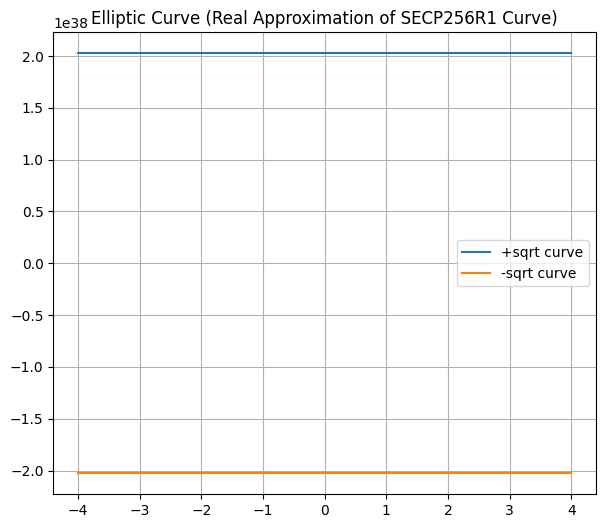

Plotting Alice & Bob EC public key points...


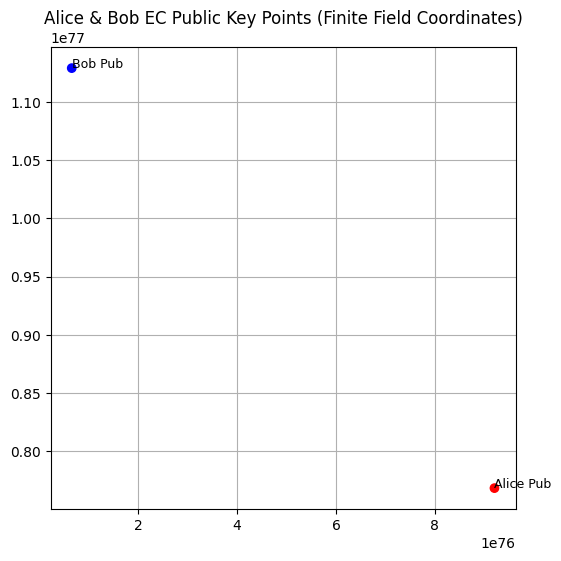

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers.aead import AESGCM
from cryptography.exceptions import InvalidSignature

# ----------------------------
# HELPER FUNCTIONS
# ----------------------------

def generate_ec_key(curve=ec.SECP256R1()):
    """Generate EC private and public key pair."""
    priv = ec.generate_private_key(curve)
    pub = priv.public_key()
    return priv, pub

def get_xy(public_key):
    """Extract (x, y) coordinates from EC public key."""
    nums = public_key.public_numbers()
    return nums.x, nums.y

def derive_shared_key(priv, peer_pub, length=32, info=b'ecdh-key-derivation'):
    """ECDH + HKDF to derive symmetric key."""
    shared_secret = priv.exchange(ec.ECDH(), peer_pub)
    hkdf = HKDF(
        algorithm=hashes.SHA256(),
        length=length,
        salt=None,
        info=info,
    )
    return hkdf.derive(shared_secret)

def aesgcm_encrypt(key, plaintext, aad=b''):
    """AES-GCM authenticated encryption."""
    aesgcm = AESGCM(key)
    nonce = os.urandom(12)
    ciphertext = aesgcm.encrypt(nonce, plaintext, aad)
    return nonce, ciphertext

def aesgcm_decrypt(key, nonce, ciphertext, aad=b''):
    """AES-GCM decryption."""
    aesgcm = AESGCM(key)
    return aesgcm.decrypt(nonce, ciphertext, aad)

def ecdsa_sign(priv, message):
    """ECDSA signature with SHA-256."""
    return priv.sign(message, ec.ECDSA(hashes.SHA256()))

def ecdsa_verify(pub, message, signature):
    """Verify ECDSA signature."""
    try:
        pub.verify(signature, message, ec.ECDSA(hashes.SHA256()))
        return True
    except InvalidSignature:
        return False

# ----------------------------
# 1. KEY GENERATION
# ----------------------------
alice_priv, alice_pub = generate_ec_key()
bob_priv, bob_pub = generate_ec_key()

alice_point = get_xy(alice_pub)
bob_point = get_xy(bob_pub)

print("=== PUBLIC KEYS ===")
print("Alice Public Key X:", hex(alice_point[0]))
print("Bob   Public Key X:", hex(bob_point[0]))

# ----------------------------
# 2. ECDH SHARED SECRET
# ----------------------------
alice_key = derive_shared_key(alice_priv, bob_pub)
bob_key = derive_shared_key(bob_priv, alice_pub)

print("\n=== DERIVED SHARED KEY ===")
print("Alice derived key:", alice_key.hex())
print("Bob   derived key:", bob_key.hex())
print("Keys Match? ->", alice_key == bob_key)

shared_key = alice_key

# ----------------------------
# 3. AES-GCM ENCRYPTION/DECRYPTION
# ----------------------------
plaintext = b"ECC USING AES-GCM AND ECDSA SIGNATURE"
nonce, ciphertext = aesgcm_encrypt(shared_key, plaintext)

print("\n=== AES-GCM ENCRYPTION ===")
print("Nonce      :", nonce.hex())
print("Ciphertext :", ciphertext.hex())

recovered = aesgcm_decrypt(shared_key, nonce, ciphertext)

print("Recovered  :", recovered)

# ----------------------------
# 4. ECDSA SIGN/VERIFY
# ----------------------------
signature = ecdsa_sign(alice_priv, plaintext)

print("\n=== ECDSA SIGNATURE ===")
print("Signature (DER):", signature.hex())
print("Verify with Alice pub:", ecdsa_verify(alice_pub, plaintext, signature))
print("Verify with Bob pub  :", ecdsa_verify(bob_pub, plaintext, signature))

# ----------------------------
# 5. VISUALIZATION: PLOT THE ELLIPTIC CURVE
# ----------------------------
print("\nPlotting elliptic curve...")

# y^2 = x^3 - 3x + b
a = -3
b_real = int("5AC635D8AA3A93E7B3EBBD55769886BC651D06B0CC53B0F63BCE3C3E27D2604B", 16)

xs = np.linspace(-4, 4, 400)
ys = np.sqrt(xs**3 + a*xs + b_real)

plt.figure(figsize=(7,6))
plt.plot(xs, ys, label="+sqrt curve")
plt.plot(xs, -ys, label="-sqrt curve")
plt.title("Elliptic Curve (Real Approximation of SECP256R1 Curve)")
plt.grid(True)
plt.legend()
plt.show()

# ----------------------------
# 6. VISUALIZATION: PUBLIC KEYS
# ----------------------------
print("Plotting Alice & Bob EC public key points...")

plt.figure(figsize=(6,6))
plt.scatter([alice_point[0], bob_point[0]],
            [alice_point[1], bob_point[1]],
            c=['red','blue'])

plt.text(alice_point[0], alice_point[1], "Alice Pub", fontsize=9)
plt.text(bob_point[0], bob_point[1], "Bob Pub", fontsize=9)

plt.title("Alice & Bob EC Public Key Points (Finite Field Coordinates)")
plt.grid(True)
plt.show()
